# CV6-9. 프로젝트: CAM을 만들고 평가해 보자
라이브러리 버전 확인하기
사용할 라이브러리 버전을 확인해봐요.

In [10]:
print(cam_model_path)
%ls

/aiffel/data/cam_model.h5
06project_cam_gradcam.ipynb  cam_gradcam.ipynb  Untitled.ipynb


In [11]:
print("테스트 데이터셋 개수:", tf.data.experimental.cardinality(ds_test).numpy())

테스트 데이터셋 개수: 8580


## 4. CAM 구현하기
1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

- get_one() 함수: 데이터셋(배치)에서 데이터를 하나씩 뽑는 함수
  - CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어짐

In [12]:
def get_one(ds):
    ds = ds.take(1)
    print(ds)
    sample_data = list(ds.as_numpy_iterator())
    #print("sample_data =", sample_data)
    #print(sample_data[0])
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]
print('슝=3')

슝=3


<TakeDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>
116


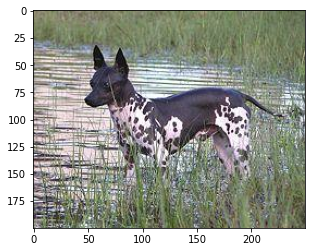

In [37]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [38]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    ########################################
    print("predictions =", predictions[0][0])
    
    max_val= np.max(predictions)
    print("max_val =", max_val)
    print(tf.rank(predictions).numpy())
    max_idx = tf.argmax(predictions, 1).numpy()
    print("max_idx =", max_idx)
    ########################################
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    ########################################
    print("conv_outputs.shape=", conv_outputs.shape) # => (7,7,2048)
    print("conv_outputs.shape[0:1] =", conv_outputs.shape[0:1]) # => (7,)
    print("conv_outputs.shape[0:2] =", conv_outputs.shape[0:2]) # => (7,7)
    print("class_weights.shape =", class_weights.shape) # => (2048, 120)
    ########################################
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
        #print("i=", i, "w=", w, "class_idx =", class_idx)

    
    print("class_idx =", class_idx)
    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()

    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.

    return cam_image

print('슝=3')

슝=3


2) 만든 함수로 CAM 이미지를 생성합시다.

In [39]:
cam_image = generate_cam(cam_model, item)

predictions = tf.Tensor(0.0003385175, shape=(), dtype=float32)
max_val = 0.85416955
2
max_idx = [95]
conv_outputs.shape= (7, 7, 2048)
conv_outputs.shape[0:1] = (7,)
conv_outputs.shape[0:2] = (7, 7)
class_weights.shape = (2048, 120)
class_idx = 116


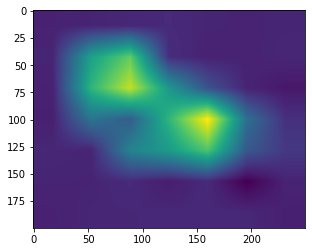

In [40]:
plt.imshow(cam_image)
plt.show()

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [41]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


- visualize_cam_on_image() 함수 사용

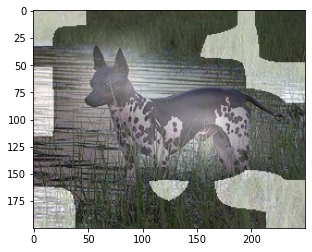

In [42]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 5. Grad-CAM 구현하기
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [43]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)  #relu 적용
    
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

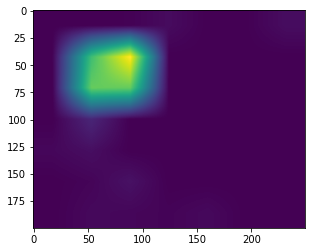

In [44]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image1)
plt.show()

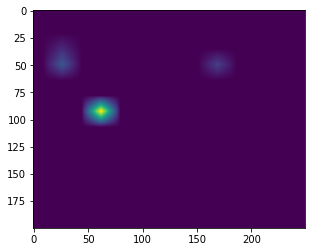

In [45]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

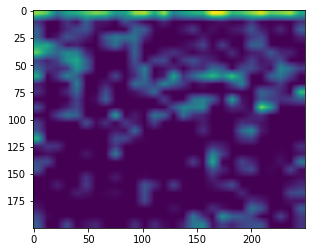

In [46]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

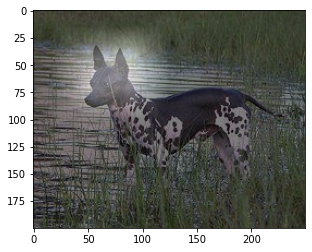

In [47]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image1_3channel = np.stack([grad_cam_image1*255]*3, axis=-1).astype(np.uint8)

blended_image1 = visualize_cam_on_image(grad_cam_image1_3channel, origin_image)
plt.imshow(blended_image1)
plt.show()

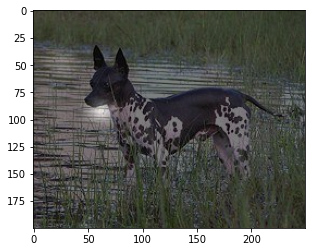

In [48]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image2_3channel = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)

blended_image2 = visualize_cam_on_image(grad_cam_image2_3channel, origin_image)
plt.imshow(blended_image2)
plt.show()

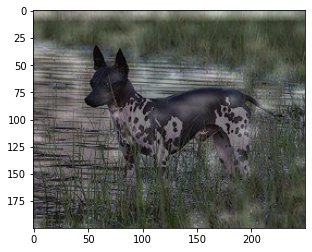

In [49]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image3_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image3 = visualize_cam_on_image(grad_cam_image3_3channel, origin_image)
plt.imshow(blended_image3)
plt.show()

## 6. 바운딩 박스 구하기
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [50]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

In [51]:
rect1 = get_bbox(cam_image)
rect1

array([[ 19, 152],
       [ 21,  14],
       [250,  18],
       [248, 156]])

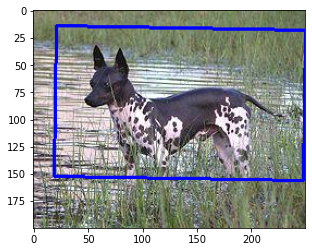

In [52]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
plt.imshow(image1)
plt.show()

[[ 20  16]
 [122  16]
 [122 122]
 [ 20 122]]


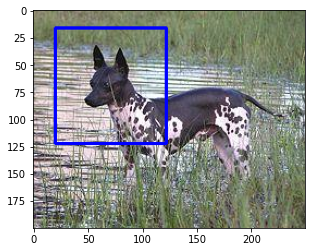

In [53]:
rect2 = get_bbox(grad_cam_image1)
print(rect2)
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)
plt.imshow(image2)
plt.show()

## 7. IoU 구하기
1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [54]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [55]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


위에서 구했던 rect를 minmax bbox 형태로 치환해 봅시다.

#### [CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU]

In [56]:
print(rect1)
pred_bbox1 = rect_to_minmax(rect1, item['image'])
print(pred_bbox1)

[[ 19 152]
 [ 21  14]
 [250  18]
 [248 156]]
[0.07, 0.076, 0.78, 1.0]


- 이 데이터의 ground truth bbox 확인

In [57]:
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

In [58]:
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.6712291804779614

#### [Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU]

In [59]:
print(rect2)
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[[ 20  16]
 [122  16]
 [122 122]
 [ 20 122]]


[0.08, 0.08, 0.61, 0.488]

In [60]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.23977863847682748

## 프로젝트 목차
1. 필요 라이브러리 import, 데이터셋 로드 및 함수 정의
2. CAM을 위한 모델 만들기
3. CAM 모델 학습하기
4. CAM 구현하기
5. Grad-CAM 구현하기
6. 바운딩박스 구하기
7. IoU 구하기

# 프로젝트 평가

| 평가문항 | 상세기준 | 수행 결과 |
|:---|:---|:---|
|  1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가? | ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다. | 3 부분 참고. <br> 수렴하였음.  |
| 2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? | CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다. | 4, 5 참고. <br> 예제에 따라서는 Grad-CAM의 경우 엉뚱한 위치를 시각화하는 케이스들이 발견되었다. 또한 원본 이미지와 CAM 이미지를 입력으로 받아 두 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수 실행 결과 이미지가 이상하게 나타나는 경우도 발견되었다. |
| 3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? | CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다. | 7 참고. <br> IoU 계산 결과로는 대부분의 경우 CAM의 성능이 우수하였다 (IoU 값이 큼) | 


### [회고]
- "예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요."라고 하였으나, 예제 코드를 그대로 썼다.
  - CAM, Grad-CAM 이론은 이해하였으나 예제 코드 이해하기도 벅차다.
  - 예제 코드에서 사용한 tensorflow, cv2, numpy의 각종 함수를 파악하는 것도 힘들다.
    - 특히 바운딩박스 생성 및 IoU 구하기에 사용된 다수의 cv2 함수들 파악...
  - Grad-CAM 생성 함수에 교재에는 없는 ReLU 적용 부분을 추가하였다.
    - def generate_grad_cam(model, activation_layer, item): 함수
    - "grad_cam_image = tf.math.maximum(0, grad_cam_image)  #relu 적용" 추가
- Explainable AI를 위해서 CAM(Class Activation MAp)과 Grad-CAM을 생성하였다.
  - CAM보다는 Grad-CAM이 실행된 AI에 대한 설명 범위가 훨씬 더 넓다고 할 수 있다.
  - CAM, Grad-CAM은 모두 weight 계산 결과를 화면에 디스플레이 하므로써, 인풋의 어느 부분을 보고 분류를 해서 결과를 냈다는 것을 보여준다.
  - 그러나 weight가 어떻게 만들어졌는지에 대한 설명은 제시하지 못한다.
  - 이 정도로 Explainable AI라고 할 수 있을까???
  - CNN의 피처맵 시각화와 별다른 큰 차이가 없는 듯하다.
- 예제에 따라서는 Grad-CAM의 경우 엉뚱한 위치를 시각화하는 케이스들이 발견되었다.
- 원본 이미지와 CAM 이미지를 입력으로 받아 두 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수 실행 결과 이미지가 이상하게 나타나는 경우도 발견되었다.
- 두 경우 모두에 대한 원인분석은 못하였다...
  - 핑계를 대자면 시간이 부족하다 ^^ (다음 과제 해야 함)
  